In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [16]:
import ale_py
gym.register_envs(ale_py)

In [17]:
class ConvDQN(nn.Module):
    def __init__(self, input_channels, action_size):
        super(ConvDQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Calculate correct feature size dynamically
        self.feature_size = self._get_conv_output_size()
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512, action_size)
        )
    
    def _get_conv_output_size(self):
        """Calculate the output size of conv layers"""
        with torch.no_grad():
            dummy_input = torch.zeros(1, 2, 84, 84)  # 2 channels, 84x84
            conv_output = self.conv(dummy_input)
            return conv_output.numel() // conv_output.size(0)  # Flatten size per sample
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), action, reward, np.array(next_state), done
    
    def __len__(self):
        return len(self.buffer)

def preprocess_frame(frame):
    import cv2
    gray = np.mean(frame, axis=2).astype(np.uint8)
    cropped = gray[34:194, :]
    resized = cv2.resize(cropped, (84, 84), interpolation=cv2.INTER_AREA)
    return resized.astype(np.float32) / 255.0

class FrameStack:
    def __init__(self, num_frames=2):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
    
    def reset(self, frame):
        processed_frame = preprocess_frame(frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return self.get_stacked()
    
    def step(self, frame):
        processed_frame = preprocess_frame(frame)
        self.frames.append(processed_frame)
        return self.get_stacked()
    
    def get_stacked(self):
        return np.stack(list(self.frames), axis=0)

In [18]:
def train_dqn():
    env = gym.make('PongNoFrameskip-v4')
    
    action_size = env.action_space.n
    lr = 0.0001
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    batch_size = 32
    buffer_size = 100000
    target_update = 1000
    mean_reward_bound = 19.5
    frame_skip = 4
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    main_net = ConvDQN(input_channels=2, action_size=action_size).to(device)
    target_net = ConvDQN(input_channels=2, action_size=action_size).to(device)
    target_net.load_state_dict(main_net.state_dict())
    
    optimizer = optim.Adam(main_net.parameters(), lr=lr)
    buffer = ReplayBuffer(buffer_size)
    
    episode_rewards = []
    mean_rewards = []
    episode = 0
    
    while True:
        state, _ = env.reset()
        frame_stack = FrameStack(2)
        stacked_state = frame_stack.reset(state)
        total_reward = 0
        done = False
        
        while not done:
            if random.random() > epsilon:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(stacked_state).unsqueeze(0).to(device)
                    q_values = main_net(state_tensor)
                    action = q_values.max(1)[1].item()
            else:
                action = env.action_space.sample()
            
            step_reward = 0
            for _ in range(frame_skip):
                next_state, reward, terminated, truncated, _ = env.step(action)
                step_reward += reward
                if terminated or truncated:
                    break
            
            done = terminated or truncated
            next_stacked_state = frame_stack.step(next_state)
            
            buffer.push(stacked_state, action, step_reward, next_stacked_state, done)
            stacked_state = next_stacked_state
            total_reward += step_reward
            
            if len(buffer) > batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                
                states = torch.FloatTensor(states).to(device)
                actions = torch.LongTensor(actions).to(device)
                rewards = torch.FloatTensor(rewards).to(device)
                next_states = torch.FloatTensor(next_states).to(device)
                dones = torch.BoolTensor(dones).to(device)
                
                current_q_values = main_net(states).gather(1, actions.unsqueeze(1))
                
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    target_q_values = rewards + (gamma * next_q_values * ~dones)
                
                loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(main_net.parameters(), max_norm=10)
                optimizer.step()
        
        if episode % target_update == 0:
            target_net.load_state_dict(main_net.state_dict())
        
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        episode_rewards.append(total_reward)
        mean_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
        
        if mean_reward >= mean_reward_bound:
            print(f"Environment solved in {episode} episodes with mean reward: {mean_reward:.2f}")
            break
        
        if episode % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:]) if len(episode_rewards) >= 10 else np.mean(episode_rewards)
            mean_rewards.append(avg_reward)
            print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.3f}, Buffer: {len(buffer)}")
            
            if episode > 0 and len(mean_rewards) > 1:
                clear_output(wait=True)
                plt.figure(figsize=(12, 5))
                
                plt.subplot(1, 2, 1)
                plt.plot(range(0, episode + 1, 10), mean_rewards, 'b-', linewidth=2, marker='o')
                plt.title('CNN-DQN Pong Training Progress')
                plt.xlabel('Episode')
                plt.ylabel('Mean Reward (last 10 episodes)')
                plt.grid(True, alpha=0.3)
                plt.axhline(y=mean_reward_bound, color='r', linestyle='--', label=f'Target ({mean_reward_bound})')
                plt.legend()
                
                plt.subplot(1, 2, 2)
                plt.plot(range(len(mean_rewards)), mean_rewards, 'g-', linewidth=2)
                plt.title('Training Progress Detail')
                plt.xlabel('Episodes (x10)')
                plt.ylabel('Average Reward')
                plt.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
                torch.save({
                    'episode': episode,
                    'model_state_dict': main_net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'avg_reward': avg_reward,
                    'epsilon': epsilon,
                    'episode_rewards': episode_rewards
                }, f'pong_cnn_dqn_episode_{episode}.pth')

        episode += 1
    
    env.close()
    return main_net

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
# Test CNN architecture
env = gym.make('PongNoFrameskip-v4')
state, _ = env.reset()

print(f"Original frame shape: {state.shape}")

processed = preprocess_frame(state)
print(f"Processed frame shape: {processed.shape}")

frame_stack = FrameStack(2)
stacked = frame_stack.reset(state)
print(f"Stacked frames shape: {stacked.shape}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_net = ConvDQN(input_channels=2, action_size=env.action_space.n).to(device)

with torch.no_grad():
    state_tensor = torch.FloatTensor(stacked).unsqueeze(0).to(device)
    q_values = cnn_net(state_tensor)
    print(f"Network input shape: {state_tensor.shape}")
    print(f"Q-values shape: {q_values.shape}")
    print(f"Q-values: {q_values.cpu().numpy()}")

total_params = sum(p.numel() for p in cnn_net.parameters())
print(f"\nTotal parameters: {total_params:,}")

env.close()

Original frame shape: (210, 160, 3)
Processed frame shape: (84, 84)
Stacked frames shape: (2, 84, 84)
Network input shape: torch.Size([1, 2, 84, 84])
Q-values shape: torch.Size([1, 6])
Q-values: [[ 0.00211418 -0.02597829  0.00547892 -0.02447201 -0.00788303 -0.02076797]]

Total parameters: 3,354,278


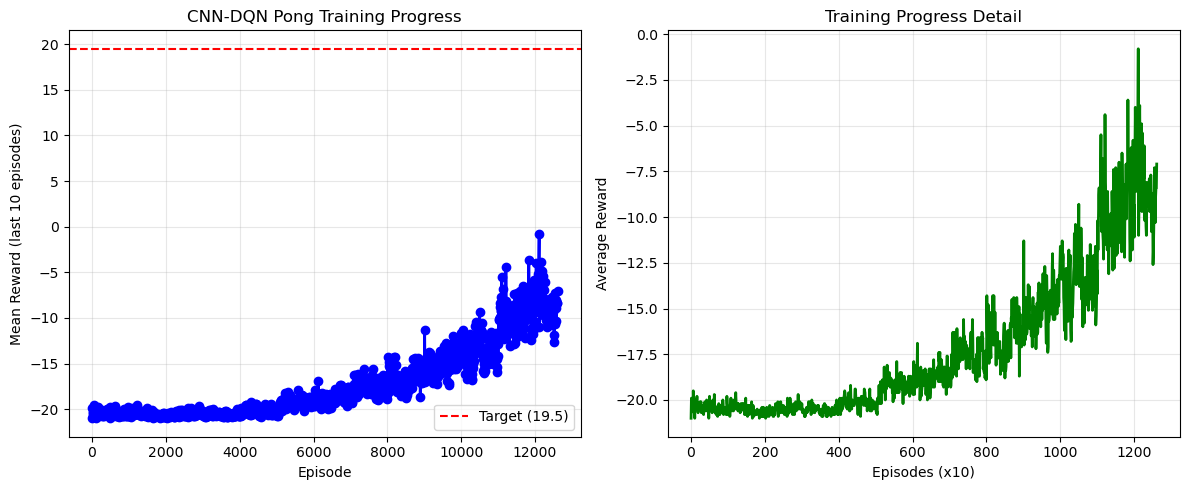

KeyboardInterrupt: 

In [21]:
# Train the CNN-based DQN
trained_model = train_dqn()
print("CNN-DQN Training completed!")